In [99]:
save_path = "/Users/aljoscha/Downloads/locustVR_data"

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import importlib

plt.style.use('default')

from LocustVR_data_analysis import utils_local
importlib.reload(utils_local)

from LocustVR_data_analysis.utils_local import default_style


In [100]:
data = pd.read_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

## 1. Individual locusts preference throughout choices

### trial preferences
- input:
    - **df:** dataframe containing ['ts', 'trial_id', 'state_type', 'animal_id', 'heading_rel_flip', 'constant_distance', 'constant_speed']
        - **animal ID:** currently int from 0 to number of animals - 1 not animal ID string in google sheet
    - **time window:** start-end in seconds after start of choice phase
    - **threshold:** angle in degrees to determine choice
- preference determination:
    - metric: mean angle of heading during time window
    - rules:
        - if metric < -threshold [°]: choice = const_speed
        - elif metric \> threshold [°]: choice = const_size
        - else: neutral
- output:
    - **df_choice_phase:** df['choice']: -1 (const_speed), 0 (neutral), 1 (const_size)
#### Abbreviations:
- **DV:** distance-velocity (using heading_rel_flip)
- **RL:** right-left (using heading_rel)

In [137]:
def trial_preferences(df, time_window=None, threshold=45, RL=False):
    if time_window is None:
        time_window = [6, 8]  # in s

    mask_time = df["ts"].between(time_window[0] * 100, time_window[1] * 100)
    df_choice_phase = df.loc[mask_time].copy()

    def compute_choice(metric, choice_col):
        df_choices = (
            df_choice_phase
            .groupby(["animal_id", "trial_id"])[metric]
            .mean()
            .reset_index()
        )

        for _, row in df_choices.iterrows():
            animal_id = row["animal_id"]
            trial_id = row["trial_id"]
            mean_heading_angle = row[metric]

            if mean_heading_angle < np.radians(-threshold):
                choice = -1  # const_speed
            elif mean_heading_angle > np.radians(threshold):
                choice = 1   # const_size
            else:
                choice = 0   # neutral

            mask = (
                (df_choice_phase["animal_id"] == animal_id)
                & (df_choice_phase["trial_id"] == trial_id)
            )
            df_choice_phase.loc[mask, choice_col] = choice

    compute_choice(metric="heading_rel_flip", choice_col="choice_DV")

    if RL:
        compute_choice(metric="heading_rel", choice_col="choice_RL")

    return df_choice_phase

# test
# plt.scatter(df_choice_phase['mean_heading_angle'], df_choice_phase['choice'])

#### usage

In [102]:
df_0 = data.copy()
time_window_0 = [6, 8]  # in s
threshold_0 = 45

df_choice = trial_preferences(df_0, time_window_0, threshold_0)

# print(df_choice["choice"].value_counts())
# plt.scatter(df_choice["mean_heading_angle"], df_choice["choice"])
# plt.show

### plot
- input:
    - df
    - animal ID
    - face color (choices [const_distance, const_speed])
    - save_fig (True/False)
- output:
    - scatter plot: y (choices [const_size, neutral, const_speed]) over x (trials)
    - color code:
        - face color: const_speed
        - edge color: const_distance
    - shape code:
        - state_type

In [124]:
def plot_individual_preferences(df, animal_id, face_color, save_fig = False, show_plot = True):

    edge_color = 'constant_distance' if face_color == 'constant_speed' else 'constant_speed'

    mask_animal = df["animal_id"] == animal_id
    df_plot = df.loc[mask_animal].copy()

    cmap = plt.cm.viridis
    color_map = {5: cmap(1.0), 3: cmap(0.5), 1: cmap(0.0)}
    color_map2 = {5: cmap(1.0), 10: cmap(0.5), 20: cmap(0.0)}

    # color_map = {5: 'red', 3: 'orange', 1: 'yellow'}
    # color_map2 = {5: 'red', 10: 'orange', 20: 'yellow'}
    marker_map = {1: 'o', 2: 's'}  # circle = 'o', square = 's'

    plt.figure(figsize=(10, 8))

    df_plot['color'] = df_plot[face_color].map(color_map)
    df_plot['edge_color'] = df_plot[edge_color].map(color_map2)
    df_plot['marker'] = df_plot['state_type'].map(marker_map)

    choice_map = {'const_speed': -1, 'neutral': 0, 'const_size': 1}

    print(df_plot.head())

    for m, sub in df_plot.groupby('marker'):
        plt.scatter(sub['trial_id'], sub['choice'],
                    color=sub['color'], marker=m,
                    edgecolor=sub['edge_color'], alpha=1, label=f'marker={m}', s=180, linewidths=2)
        plt.yticks(list(choice_map.values()), list(choice_map.keys()))

    # plt.xlabel("Trial ID")
    # plt.ylabel("Choice")
    # plt.title(f"animal{animal_id}")
    #plt.tight_layout()

    legend = f"animal {animal_id}"
    default_style("Trial ID", "Choice", title=legend, fontsize1=20, fontsize2=16)
    if save_fig:
        plt.savefig(os.path.join(save_path, f'individual_{animal_id}_choices.pdf'), format='pdf')
    if show_plot:
        plt.show()

#### usage

                X          Y   heading   ts  trial_id  state_type  animal_id  \
1079835  3.508199  18.018414  3.329644  600         0           1          3   
1079836  3.503037  18.013051  3.351688  601         0           1          3   
1079837  3.497964  18.007780  3.351688  602         0           1          3   
1079838  3.492989  18.002616  3.340236  603         0           1          3   
1079839  3.488115  17.997566  3.340236  604         0           1          3   

         heading_rel  heading_rel_flip  constant_distance  ...  X_aligned  \
1079835    -3.136492         -3.136492                 20  ...  -0.465732   
1079836    -3.114448         -3.114448                 20  ...  -0.471783   
1079837    -3.114448         -3.114448                 20  ...  -0.477731   
1079838    -3.125900         -3.125900                 20  ...  -0.483562   
1079839    -3.125900         -3.125900                 20  ...  -0.489274   

         Y_aligned    Y_flip  directness  angle_direct  

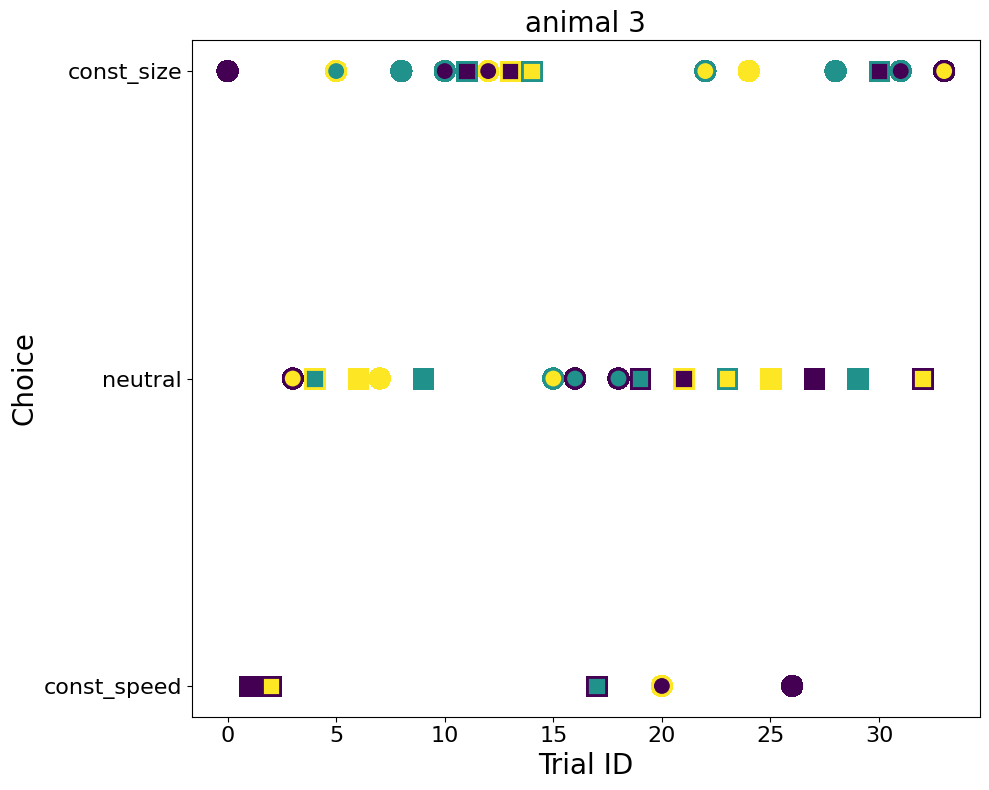

'plot every animal'

In [128]:
face_color_0 = 'constant_speed'  # 'constant_distance' or 'constant_speed'

"""plot one animal"""
animal_id_0 = 3
plot_individual_preferences(df_choice, animal_id_0, face_color_0, save_fig=True, show_plot=True)

"""plot every animal"""
# for animal_id in range(len(df_0['animal_id'].unique())):
#     plot_individual_preferences(df_choice, animal_id, face_color_0, save_fig=True, show_plot=False)


#### legend for individual choice plots

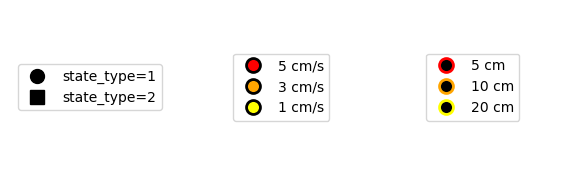

In [44]:
# legend
fig, ax = plt.subplots(1, 3, figsize=(7, 2))

marker_map = {1: 'o', 2: 's'}  # circle = 'o', square = 's'
color_map = {5: 'red', 3: 'orange', 1: 'yellow'}
color_map2 = {5: 'red', 10: 'orange', 20: 'yellow'}

mappings = [marker_map, color_map, color_map2]

for i, map in enumerate(mappings):
    for key, value in map.items():
        if i == 0:
            legend_element = mlines.Line2D([], [], color='black', marker=value, linestyle='None',
                                           markersize=10, label=f'state_type={key}')
        elif i == 1:
            legend_element = mlines.Line2D([], [], color=value, marker='o', linestyle='None',
                                           markersize=10, label=f'{key} cm/s', markeredgecolor='black',markeredgewidth=2)
        else:
            legend_element = mlines.Line2D([], [], color='black', marker='o', markeredgecolor=value,
                                           markeredgewidth=2, linestyle='None',
                                           markersize=10, label=f'{key} cm')
        ax[i].add_line(legend_element)
    ax[i].legend(loc='center')
    ax[i].axis('off')

plt.savefig(os.path.join(save_path, f'legend.pdf'), format='pdf')
plt.show()

## 2. preference across different starting distances

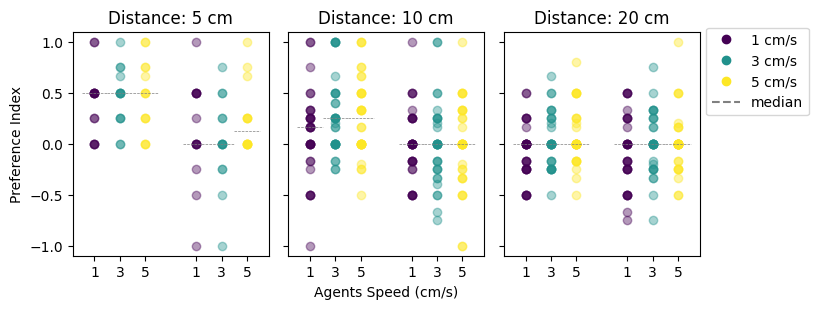

In [181]:
# divide in dist 1-3 (5, 10, 20 cm)
# preference index function
# apply angle rel + angle rel flip
# plot subplots 3
# show const x, pi = y
# Q: first pi (within trials) or first discrete threshold then pi (over trials)?

# new df constant_distance [5, 10, 20], constant_speed [1, 3, 5],

const_dist_0 = 10  # in cm

# def preference_index(array):
#     # preference index PI = (n_1 - n_-1) / (n_1 + n_0 + n_-1) = n_1 / (n_1 + n_0 + n_-1) - n_-1 / (n_1 + n_0 + n_-1)
#     pi = array.value_counts(1)[1] - array.value_counts()[-1]
#     return pi

def preference_index(array):
    counts = array.value_counts(normalize=False)  # or normalize=True if you prefer
    n_pos = counts.get(1, 0)
    n_neg = counts.get(-1, 0)
    n_total = counts.sum()
    if n_total == 0:
        return np.nan
    return (n_pos - n_neg) / n_total

fig, ax = plt.subplots(1, 3, figsize=(7, 3), sharey='all')
df_choice_plot = trial_preferences(df_0, time_window_0, threshold_0, RL=True)
for i, dist in enumerate(df_choice_plot["constant_distance"].unique()):
    mask_dist = df_choice_plot["constant_distance"] == dist
    df_dist = df_choice_plot.loc[mask_dist].copy()

    cmap = plt.cm.viridis
    color_map_speed = {5: cmap(1.0), 3: cmap(0.5), 1: cmap(0.0)}
    def half_sub_plot(df, choice_col):
        if choice_col == "choice_DV":
            map_speed = {1: 1, 3: 2, 5: 3}
            map_speed = {1: 1, 3: 2, 5: 3}
        else:
            map_speed = {1: 5, 3: 6, 5: 7}
            map_speed = {1: 5, 3: 6, 5: 7}

        df_speed_animal = df_dist.groupby(["constant_speed" ,"animal_id"])[choice_col].apply(preference_index).reset_index()
        ax[i].set_title(f"Distance: {dist} cm")
        for speed in df_speed_animal["constant_speed"].unique():
            mask_speed = df_speed_animal["constant_speed"] == speed
            df_speed = df_speed_animal.loc[mask_speed].copy()
            ax[i].scatter([map_speed[speed]]*len(df_speed), df_speed[choice_col], label=f"Speed {speed} cm/s", alpha=0.4, color=color_map_speed[speed])
            ax[i].plot([map_speed[speed]-0.5, map_speed[speed]+0.5], [np.median(df_speed[choice_col]), np.median(df_speed[choice_col])], color='gray', linestyle='--', linewidth=0.5)
        ax[i].set_xticks([1, 2, 3, 5, 6, 7], ['1', '3', '5', '1', '3', '5'])

    half_sub_plot(df_dist, "choice_DV")
    half_sub_plot(df_dist, "choice_RL")

plt.tight_layout()

ax[0].set_ylabel("Preference Index")
ax[1].set_xlabel("Agents Speed (cm/s)")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=cmap(0.), marker='o', linestyle='None'),
                Line2D([0], [0], color=cmap(.5), marker='o', linestyle='None'),
                Line2D([0], [0], color=cmap(1.), marker='o', linestyle='None'),
                Line2D([0], [0], color="gray", marker='None', linestyle='--')]
ax[2].legend(custom_lines, ["1 cm/s", "3 cm/s", "5 cm/s", "median"], bbox_to_anchor=(1.0, 1.05))

# plt.savefig(os.path.join(save_path, f'preference_index_distance_subplots.pdf'), format='pdf')
plt.savefig(os.path.join(save_path, 'preference_index_distance_subplots.pdf'),
            format='pdf', bbox_inches='tight')
plt.show()






# print(df_choice["choice"].value_counts(1))
# print(df_choice["choice"].value_counts()[-1])
# print(df_choice["choice"].value_counts())





constant_distance  constant_speed
5                  1                 22
                   3                 26
                   5                 20
10                 1                 34
                   3                 35
                   5                 35
20                 1                 32
                   3                 33
                   5                 36
Name: trial_id, dtype: int64


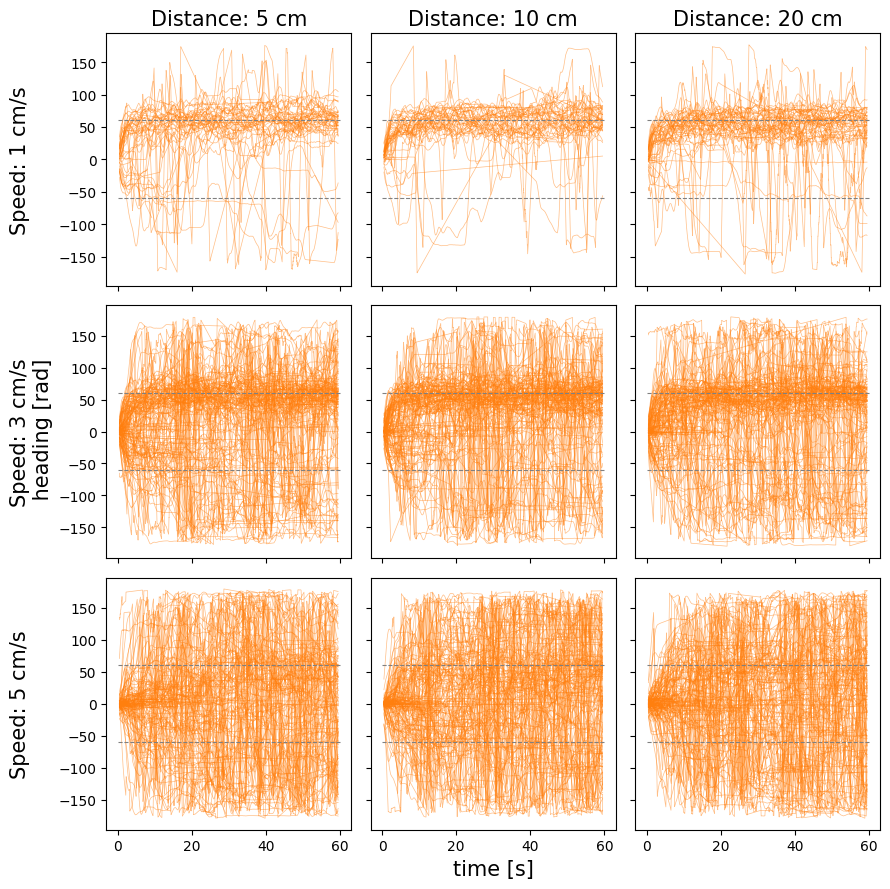

In [232]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9), sharey='row', sharex='col')
mask_time = df_0["ts"].between(0, 6000)
df_condition = df_0[mask_time].groupby(
    ["constant_distance", "constant_speed", "animal_id", "trial_id"]
)


print(df_0[mask_time].groupby(["constant_distance", "constant_speed"])["trial_id"].nunique())



for i, dist in enumerate(sorted(df_0["constant_distance"].unique())):
    for j, speed in enumerate(sorted(df_0["constant_speed"].unique())):
        for (d, s, a, t), group in df_condition:
            if d == dist and s == speed:
                # ax[i, j].plot(group["ts"]/100, np.degrees(group["heading_rel_flip"]),
                #               color='C1', linewidth=0.3, alpha=0.4)
                ax[i, j].plot(group["ts"]/100, np.degrees(group["heading_rel_flip"].rolling(window=100, center=True).mean()),
                              color='C1', linewidth=0.5, alpha=0.5)

        ax[i, j].hlines([60, -60], 0, 60, colors='gray', linestyles='--', linewidth=0.8)
        if i == 0:
            # ax[i, j].set_title(f"Distance: {dist} cm", fontsize=15)
            ax[i, j].set_title(f"Distance: {sorted(df_0["constant_distance"].unique())[j]} cm", fontsize=15)
        if i == 2:
            if j == 1:
                ax[i, j].set_xlabel("time [s]", fontsize=15)


ax[0, 0].set_ylabel(f"Speed: {sorted(df_0["constant_speed"].unique())[0]} cm/s\n", fontsize=15)
ax[1, 0].set_ylabel(f"Speed: {sorted(df_0["constant_speed"].unique())[1]} cm/s\n heading [rad]", fontsize=15)
ax[2, 0].set_ylabel(f"Speed: {sorted(df_0["constant_speed"].unique())[2]} cm/s\n", fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'heading_rel_flip_distance_speed_subplots.png'), dpi=600)
plt.show()